In [257]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
from matplotlib import animation


from sympy import exp, sin, cos, symbols
from sympy.utilities.lambdify import lambdify

np.set_printoptions(linewidth=np.inf)

In [258]:
# accuracy and range of x, y, and t
x_i, x_f = (0,np.pi)
y_i, y_f = (0,np.pi)
t_i, t_f = (0,1)

L_x = x_f - x_i
L_y = y_f - y_i

x_points = 20
y_points = 20
t_points = 1000

# variables that will be used later
x_delta = (x_f - x_i) / (x_points - 1)
y_delta = (y_f - y_i) / (y_points - 1)
t_delta = (t_f - t_i) / (t_points - 1)

x = np.linspace(x_i, x_f, x_points)
y = np.linspace(y_i, y_f, y_points)
t = np.linspace(t_i, t_f, t_points)

nodes = x_points * y_points
nonboundary_nodes = (x_points - 2) * (y_points - 2)

# animation settings
duration = 5
animation_interval = 1000 * duration / t_points # t_points = frames
repeat_delay = 100000
cmap = 'Wistia'

In [259]:
# Convection-Diffusion Equation
xv, yv = np.meshgrid(x, y)
xt, tx = np.meshgrid(x, t)
yt, ty = np.meshgrid(y, t)
x_symbol, y_symbol, t_symbol = symbols('x y t')

# dv/dt + R * (u * ∇) u = -∇p + μ∇^2u + f
# let U = [u, v] (or [u, v, w] in 3D)
# du/dt + R * (u du/dx + v du/dy) = -dp/dx + μ(d2u/dx2 + d2u/dy2) + f_u
# dv/dt + R * (u dv/dx + v dv/dy) = -dp/dy + μ(d2v/dx2 + d2v/dy2) + f_v
# (next line is only for 3d)
# dw/dt + R * (u dw/dx + v dw/dy + w dw/dz) = -dp/dz + μ(d2w/dx2 + d2w/dy2 + d2w/dz2) + f_w
# technically there should be a density term, but I'm going to assume the density is 1 for now

# constants
mu = .1
r = 1 # in the equation it is capital R, but I want to use that variable later

# intial conditions
ui = -cos(x_symbol) * sin(y_symbol)
vi = sin(x_symbol) * cos(x_symbol)
pi = -(cos(2 * x_symbol) + cos(2 * y_symbol)) / 4

ui = np.vectorize(lambdify([x_symbol, y_symbol], ui))
vi = np.vectorize(lambdify([x_symbol, y_symbol], vi))
pi = np.vectorize(lambdify([x_symbol, y_symbol], pi))

init_x = ui(xv, yv)
init_y = vi(xv, yv)
init_p = pi(xv, yv)

# forcing function
E_x = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], 0))
E_y = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], 0))

# boundary conditions
u_x_0 = 0
u_x_L = 0
u_y_0 = -sin(y_symbol) * exp(-2 * t_symbol)
u_y_L = sin(y_symbol) * exp(-2 * t_symbol)

v_y_0 = 0
v_y_L = 0
v_x_0 = sin(x_symbol) * exp(-2 * t_symbol)
v_x_L = -sin(x_symbol) * exp(-2 * t_symbol)

p_x_0 = -(cos(2 * x_symbol) * exp(-4 * t_symbol)) / 4
p_x_L = -(cos(2 * x_symbol) * exp(-4 * t_symbol)) / 4
p_y_0 = -(cos(2 * y_symbol) * exp(-4 * t_symbol)) / 4
p_y_L = -(cos(2 * y_symbol) * exp(-4 * t_symbol)) / 4

# convert the sympy expression objects into numpy vectorize objects so it works with the meshgrid
u_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], u_x_0))
u_x_L = np.vectorize(lambdify([x_symbol, t_symbol], u_x_L))
u_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], u_y_0))
u_y_L = np.vectorize(lambdify([y_symbol, t_symbol], u_y_L))

v_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], v_y_0))
v_y_L = np.vectorize(lambdify([y_symbol, t_symbol], v_y_L))
v_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], v_x_0))
v_x_L = np.vectorize(lambdify([x_symbol, t_symbol], v_x_L))

p_x_0 = np.vectorize(lambdify([x_symbol, t_symbol], p_x_0))
p_x_L = np.vectorize(lambdify([x_symbol, t_symbol], p_x_L))
p_y_0 = np.vectorize(lambdify([y_symbol, t_symbol], p_y_0))
p_y_L = np.vectorize(lambdify([y_symbol, t_symbol], p_y_L))

# accuracy controls for pressure evolution
l = float(x_delta ** 2 / (t_delta * sin(2 * x_delta)))
e = float(x_delta ** 3)

In [260]:
# code for generating animations

# creates the maginute scalar field from the x (u) and y (v) components
def velocity_magnitude_field(u, v):
    magnitude = lambda x, y : np.sqrt(x ** 2 + y ** 2)
    vfunc = np.vectorize(magnitude)

    return vfunc(u, v)

# assumes data has shape (t_points, x_points * y_points) 
def gen_anim(data, file_name):
    fig, ax = plt.subplots(1, 1, figsize = (6,6))

    max_z = data.min()
    min_z = data.max()
    
    print(f"max : {max_z}, min : {min_z}")

    def animate(i):
        ax.cla()

        curr_data = data[i].reshape((y_points, x_points))

        ax.pcolormesh(x, y, curr_data[:-1,:-1], cmap = plt.get_cmap(cmap), shading='flat', vmin=0, vmax=1)
        ax.set_xlim((x_i, x_f))
        ax.set_ylim((y_i, y_f))

    anim = animation.FuncAnimation(fig, animate, frames = t_points - 1, interval = animation_interval, blit = False, repeat = False)
    anim.save(file_name)

In [261]:
# Laplacian Matrix
fd_coeffs = {1 : [[-3/2, 2, -1/2], [-1/2, 0, 1/2], [1/2, -2, 3/2]], 2 : [[2, -5, 4, -1], [1, -2, 1], [-1, 4, -5, 2]]}
delta_powers = {1 : (1, 1, 1), 2: (3, 2, 3)}

def derivative_1d(points : int, delta : float, order = int):
    forward, central, backward = fd_coeffs[order]
    delta_power = delta_powers[order]

    mat = np.zeros((points, points))
    for i in range(1, points - 1): mat[i, i-1:i+ len(central) - 1] = [x / delta ** delta_power[1] for x in central]
    
    mat[0][0:len(forward)] = [x / delta ** delta_power[0] for x in forward]
    mat[-1][-len(backward):] = [x / delta ** delta_power[2] for x in backward]

    return mat

def derivative_2d(x_points : int, x_delta : float, y_points : int, y_delta : int, order = int):
    return np.kron(derivative_1d(y_points, y_delta, order), np.eye(x_points)) + np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, order))

In [262]:
# creating the evolution matrix
# let gen_mat(u_i) = A
# A * *u = u_i
def gen_mat(u_i, x_delta, order):
    # order = 0 -> u_n -> u* (pde in x)
    # order = 1 -> u* -> u** (pde in y)

    u_test = np.zeros((x_points * y_points, x_points * y_points))
    index = 0
    for i in u_i.flatten(): u_test[index] = i

    R = r * t_delta / (2 * x_delta)
    T = t_delta * mu / (x_delta ** 2)

    if order == 0:
        R_mat = np.kron(np.eye(y_points), R * derivative_1d(x_points, x_delta, 1))
        t_mat = np.kron(np.eye(y_points), np.eye(x_points) - T * derivative_1d(x_points, x_delta, 2))
    elif order == 1:
        R_mat = np.kron(R * derivative_1d(y_points, y_delta, 1), np.eye(x_points))
        t_mat = np.kron(np.eye(x_points) -T * derivative_1d(y_points, y_delta, 2), np.eye(x_points))

    return t_mat + R_mat * u_test

In [263]:
def bp(u, v, curr_t):
    # boundary conditions for u
    u[0:x_points] = u_y_0(x, curr_t)
    u[-x_points:] = u_y_L(x, curr_t)

    index = 0
    for x_val in u_x_0(y, curr_t):
        u[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in u_x_L(y, curr_t):
        u[index] = x_val
        index += x_points

    # boundary conditions for v
    v[0:x_points] = v_y_0(x, curr_t)
    v[-x_points:] = v_y_L(x, curr_t)

    index = 0
    for x_val in v_x_0(y, curr_t):
        v[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in v_x_L(y, curr_t):
        v[index] = x_val
        index += x_points

    return (u, v)

def p_bp(p, curr_t):
    p[0:x_points] = p_y_0(x, curr_t)
    p[-x_points:] = p_y_L(x, curr_t)

    index = 0
    for x_val in p_x_0(y, curr_t):
        p[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in p_x_L(y, curr_t):
        p[index] = x_val
        index += x_points

    return p

In [264]:
# restriction and prolongation matricies
P = np.zeros((nodes, nonboundary_nodes))
curr_index = 0
for i in range(nodes):
    if i > x_points and i < nodes - x_points and i % x_points not in [0,x_points-1]:
        P[i, curr_index] = 1
        curr_index += 1

R = P.transpose()
print(P.shape)
print(R.shape)

(400, 324)
(324, 400)


In [265]:
# evolves u_i to u_aux
# shape of all input vectors should be (x_points * y_points, )
def gen_u_aux(u_i_x, u_i_y, curr_t):
    u_BC, v_BC = bp(np.zeros((y_points * x_points)), np.zeros((y_points * x_points)), curr_t)
    E_i_x = E_x(xv, yv, curr_t)
    E_i_y = E_y(xv, yv, curr_t)

    u_i_x = u_i_x.flatten()
    u_i_y = u_i_y.flatten()

    Ax_star = gen_mat(u_i_x, x_delta, 0)
    Ay_star = gen_mat(u_i_y, y_delta, 0)

    star_x = (P @ (npla.inv(R @ Ax_star @ P) @ (R @ (u_i_x - Ax_star @ u_BC)))) + u_BC
    star_y = (P @ (npla.inv(R @ Ay_star @ P) @ (R @ (u_i_y - Ay_star @ u_BC))))+ v_BC

    Ax_star = gen_mat(u_i_x, x_delta, 1)
    Ay_star = gen_mat(u_i_y, y_delta, 1)

    star_star_x = (P @ (npla.inv(R @ Ax_star @ P) @ (R @ ((star_x + t_delta * E_i_x.flatten()) - Ax_star @ u_BC)))) + u_BC
    star_star_y = (P @ (npla.inv(R @ Ay_star @ P) @ (R @ ((star_y + t_delta * E_i_y.flatten()) - Ay_star @ u_BC)))) + v_BC
 
    return (star_star_x.reshape(y_points, x_points), star_star_y.reshape(y_points, x_points))

In [266]:
# generate mat based on custom stencils
def custom_mat(stencils, points):
    forward_stencil, central_stencil, backward_stencil = stencils
    mat = np.zeros((points, points))
    mat[0, 0:len(forward_stencil)] = forward_stencil
    mat[-1, -len(backward_stencil):] = backward_stencil
    for i in range(1, y_points - 1): mat[i, i - 1: i + len(central_stencil) - 1] = central_stencil

    return mat

1
0.0
current time: 0.0
1
0.0
current time: 0.001001001001001001
1
0.0
current time: 0.002002002002002002
1
0.0
current time: 0.003003003003003003
1
0.0
current time: 0.004004004004004004
1
0.0
current time: 0.005005005005005005
1
0.0
current time: 0.006006006006006006
1
0.0
current time: 0.007007007007007007
1
0.0
current time: 0.008008008008008008
1
0.0
current time: 0.009009009009009009
1
0.0
current time: 0.01001001001001001
1
0.0
current time: 0.011011011011011011
1
0.0
current time: 0.012012012012012012
1
0.0
current time: 0.013013013013013013
1
0.0
current time: 0.014014014014014014
1
0.0
current time: 0.015015015015015015
1
0.0
current time: 0.016016016016016016
1
0.0
current time: 0.017017017017017015
1
0.0
current time: 0.018018018018018018
1
0.0
current time: 0.01901901901901902
1
0.0
current time: 0.02002002002002002
1
0.0
current time: 0.02102102102102102
1
0.0
current time: 0.022022022022022022
1
0.0
current time: 0.023023023023023025
1
0.0
current time: 0.024024024024024

C:\Users\gauth\AppData\Local\Temp\ipykernel_33232\3269203132.py:38: RuntimeWarning: overflow encountered in scalar divide
  p_factor = .25 * t_delta * l * (px_factor / (x_delta ** 2) + py_factor / (y_delta ** 2))
C:\Users\gauth\AppData\Local\Temp\ipykernel_33232\3269203132.py:40: RuntimeWarning: overflow encountered in scalar multiply
  new_p = (1 - factor) * old_p[curr_x, curr_y] - l * aux_factor + l * p_factor
C:\Users\gauth\AppData\Local\Temp\ipykernel_33232\3269203132.py:54: RuntimeWarning: invalid value encountered in subtract
  if np.max(abs(p - old_p)) <= e:
C:\Users\gauth\AppData\Local\Temp\ipykernel_33232\3269203132.py:67: RuntimeWarning: invalid value encountered in subtract
  print(np.max(abs(p - old_p))) # if this increases, p does not converge
C:\Users\gauth\AppData\Local\Temp\ipykernel_33232\3269203132.py:38: RuntimeWarning: overflow encountered in scalar add
  p_factor = .25 * t_delta * l * (px_factor / (x_delta ** 2) + py_factor / (y_delta ** 2))
C:\Users\gauth\AppData\

1
nan
2
nan
3
nan
4
nan
5
nan
6
nan
7
nan
8
nan
9
nan
10
nan
11
nan
12
nan
13
nan
14
nan
15
nan
16
nan
17
nan
18
nan
19
nan
20
nan
21
nan
22
nan
23
nan
24
nan
25
nan
26
nan
max : 0.0, min : 1.0


OverflowError: (34, 'Result too large')

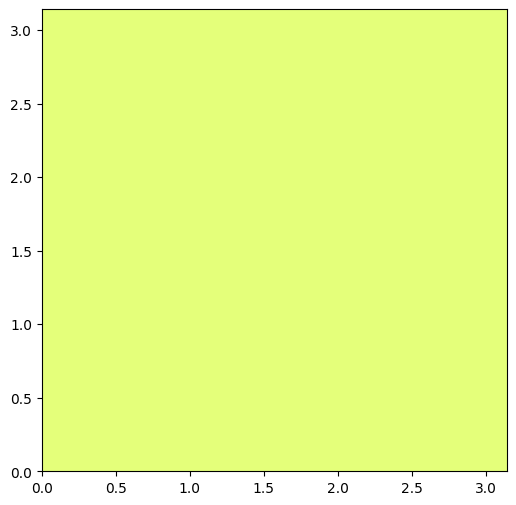

In [267]:
u = init_x
v = init_y
p = init_p

u_mat = np.zeros((t_points, x_points * y_points))
v_mat = np.zeros((t_points, x_points * y_points))
p_mat = np.zeros((t_points, x_points * y_points))

index = 0

x_range = list(range(x_points))
y_range = list(range(y_points))

error_data = np.zeros((t_points, x_points * y_points))

for curr_t in t[:-1]:
    u_aux, v_aux = gen_u_aux(u, v, curr_t)
    factor = .25 * t_delta * l * (1/(x_delta ** 2) + 1/(y_delta ** 2))

    pThresh = False

    i = 0

    while not pThresh:
        # this part of the code is incomplete, but this is where I would recursively solve equation 4b and 4c to get better and better approximations for p and u
        old_p = p
        
        # handles all nonboundary and nonpsuedoboundary points
        # pseudoboundary points are the ones one away from the boundary
        # those don't work since I need the values of p_(q+_2)
        for curr_x in x_range[2:-2]:
            for curr_y in y_range[2:-2]:
                aux_factor = (u_aux[curr_x + 1, curr_y] - u_aux[curr_x - 1, curr_y]) / (2 * x_delta) + (v_aux[curr_x, curr_y + 1] - v_aux[curr_x, curr_y - 1]) / (2 * y_delta)
                
                px_factor = old_p[curr_x + 2, curr_y] + old_p[curr_x - 2, curr_y]
                py_factor = old_p[curr_x, curr_y + 2] + old_p[curr_x, curr_y - 2]

                p_factor = .25 * t_delta * l * (px_factor / (x_delta ** 2) + py_factor / (y_delta ** 2))

                new_p = (1 - factor) * old_p[curr_x, curr_y] - l * aux_factor + l * p_factor
                p[curr_x, curr_y] = new_p / (1 + factor)

        # the boundary conditions for p are the same in a given time step.
        # I only have to update them when the timestep ends

        # I still have to change the psuedoboundary points
        # I can't think of a better way to do this other than just averaging the points on either side
        # I know its inaccurate, but its the best thing I can think of right now.
        for curr_x in x_range[1:-1]: p[curr_x, 1] = (p[curr_x, 0] + p[curr_x, 2] + old_p[curr_x, 1]) / 3
        
        # I've done the corner psuedoboundary points, so I only have to worry about the ones on the side
        for curr_y in y_range[2:-2]: p[1, curr_y] = (p[0, curr_y] + p[2, curr_y] + old_p[1, curr_y]) / 3
        
        if np.max(abs(p - old_p)) <= e: 
            pThresh = True

            # calc u and v here
            for curr_x in x_range[:-2]:
                for curr_y in y_range[1:-1]:
                    u[curr_y, curr_x + 1] = u_aux[curr_y, curr_x + 1] - t_delta / (2 * x_delta) * (old_p[curr_y, curr_x + 2] - .5 * (p[curr_y, curr_x] + old_p[curr_y, curr_x]))

            for curr_y in y_range[:-2]:
                for curr_x in x_range[1:-1]:
                    v[curr_y + 1, curr_x] = v_aux[curr_y + 1, curr_x] - t_delta / (2 * y_delta) * (old_p[curr_y + 2, curr_x] - .5 * (p[curr_y, curr_x] + old_p[curr_y, curr_y]))
        
        print(i := i + 1)
        print(np.max(abs(p - old_p))) # if this increases, p does not converge

        if i > 25: 
            gen_anim(error_data, "tmp/error_data.gif")
            
            mag = velocity_magnitude_field(u_mat, v_mat)

            gen_anim(mag, 'tmp/velocity_field.gif')
            gen_anim(p_mat, 'tmp/pressure_field.gif')
            raise Exception("p does not converge")
    
    print(f"current time: {curr_t}")
    error_data[index] = 1 * (abs(p - old_p) <= e).flatten()

    u_curr, v_curr = bp(u.flatten(), v.flatten(), curr_t)
    p_curr = p_bp(p.flatten(), curr_t)

    u_mat[index] = u_curr
    v_mat[index] = v_curr
    p_mat[index] = p_curr

    index += 1
    
mag = velocity_magnitude_field(u_mat, v_mat)

gen_anim(mag, 'tmp/velocity_field.gif')
gen_anim(p_mat, 'tmp/pressure_field.gif')